In [1]:
import healpy as hp
import lunarsky
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel2016
import pyradiosky
import pyuvdata
import numpy as np
import uvtools

fatal: No names found, cannot describe anything.


## Load 21cm models

In [2]:
# def z_to_nu(z):
#     nu_0 = 1420405751.768  # Hz
#     return nu_0 / (z+1)

# redshifts = np.loadtxt('z_EIGSEP.txt')
# freqs_models = z_to_nu(redshifts) / 1e9  # GHz
# models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

# freqs_models = freqs_models[::-1]
# models = models[:, ::-1]

In [3]:
# # load standard models
# ares_models = np.load('models_21cm.npz')
# ares_T21 = ares_models['models'] / 1e3  # mK to K
# ares_freqs = ares_models['freqs']

## Import Beams

In [4]:
uvb_path = "../luseesky/uvbeams/003/"
fname = "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.uvbeam"

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(uvb_path + fname)

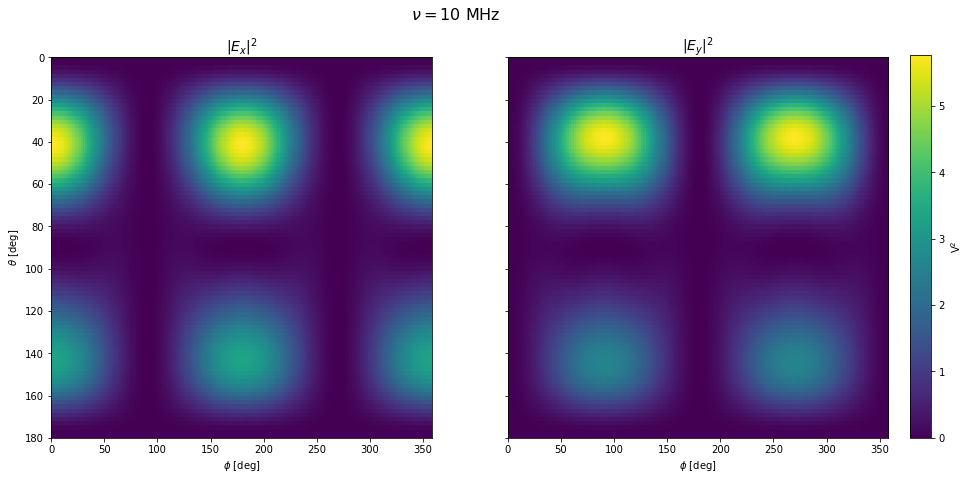

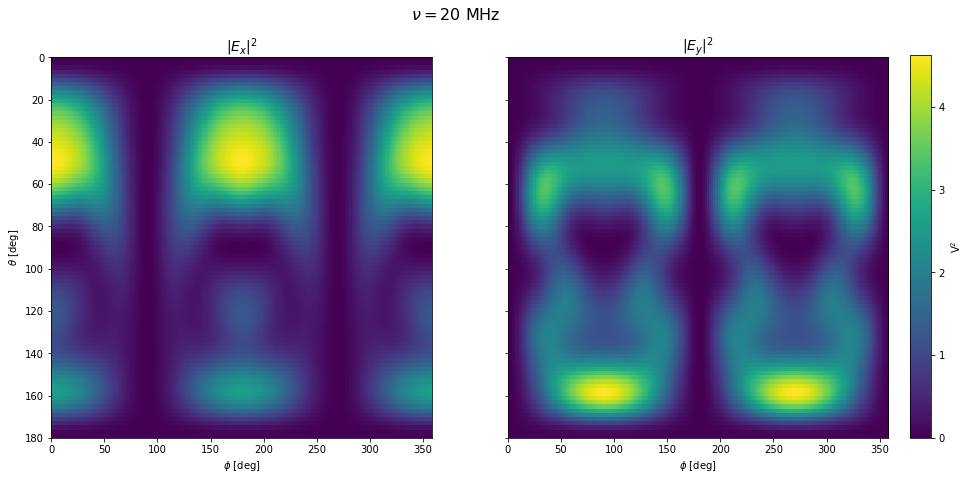

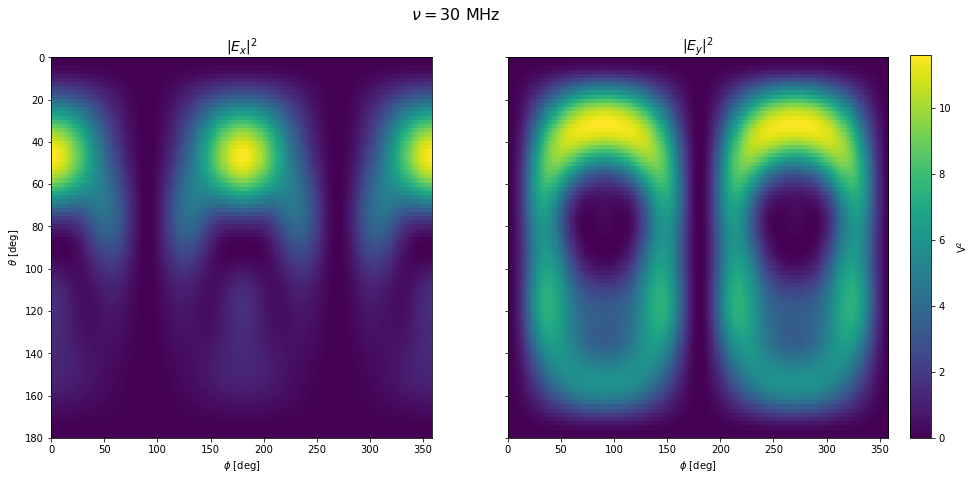

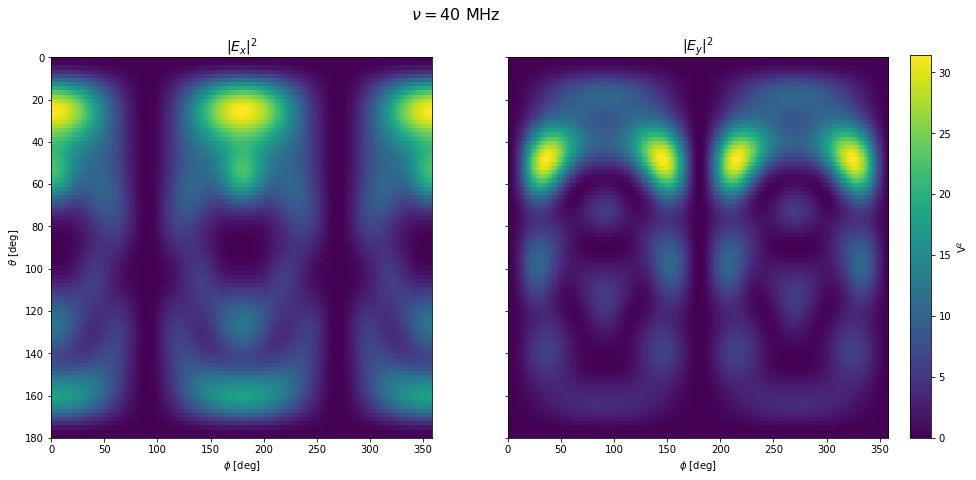

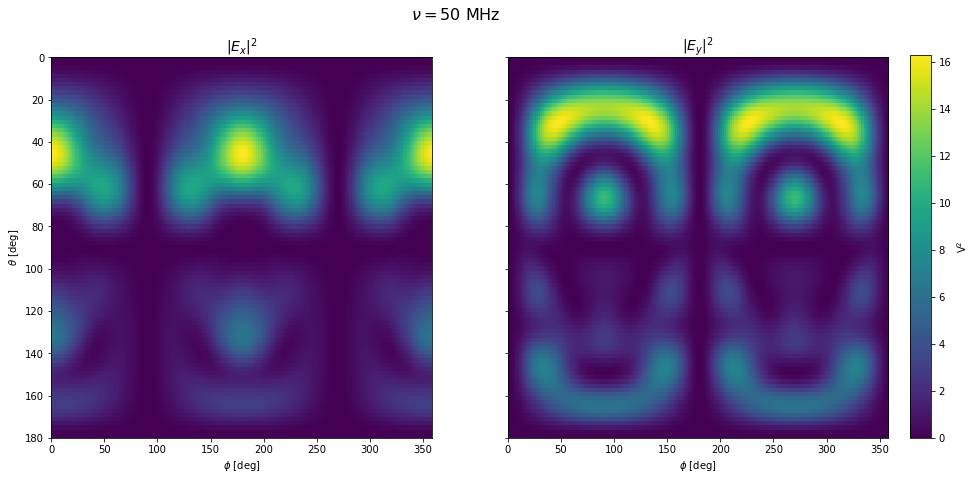

In [5]:
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
extent = [left, right, bottom, top]
components = ["$|E_x|^2$", "$|E_y|^2$"]

for freq in [10, 20, 30, 40, 50]:
    find = np.argmin(np.abs(uvb.freq_array[0] - freq*1e6))
    fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        im = ax.imshow(np.abs(uvb.data_array[i, 0, i, find])**2, interpolation="none", aspect="auto", extent=extent)
        ax.set_xlabel("$\\phi$ [deg]")
        if i == 0:
            ax.set_ylabel("$\\theta$ [deg]")
        ax.set_title(components[i], fontsize=14)
    cax=fig.add_axes([0.92, 0.125, .02, .76])
    plt.colorbar(im, cax, label="$\\rm{V}^2$")
    plt.suptitle('$\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, find]/1e6), fontsize=16)
    plt.show()

## Load skymodel

In [151]:
import healpy
rot = healpy.Rotator(coord=['G','C'])

invalid value encountered in log2


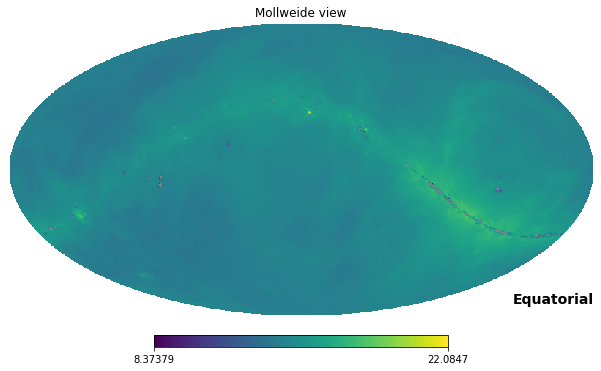

In [152]:
REF_FREQ = 25  # MHz
gsm = GlobalSkyModel2016(freq_unit='MHz')
gsm.generate(REF_FREQ)
healpy.mollview(np.log2(rot.rotate_map_pixel(gsm.generated_map_data)), rot=[0, 30, 0], coord="C")
#gsm.view(logged=True)  # calling mollview with default components, nest=False

invalid value encountered in log2


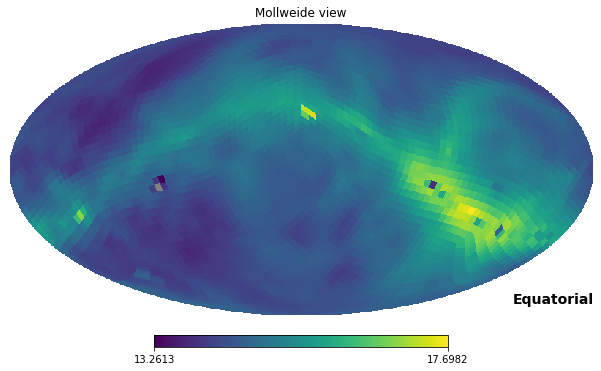

In [153]:
# averagng
degr = healpy.ud_grade(gsm.generated_map_data, nside_out=16, order_in="RING", order_out="RING")
healpy.mollview(np.log2(rot.rotate_map_pixel(degr)), rot=[0, 30, 0], coord="C")

In [124]:
# the actual sky model used after filtering
skymodel = pyradiosky.SkyModel()
skymodel.read_text_catalog("../luseesky/skymodels/pygdsm16_nside16.txt")

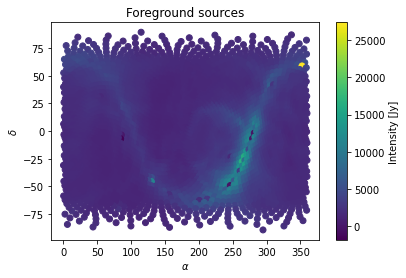

In [125]:
plt.figure()
#plt.subplot(projection="mollweide")
#plt.scatter(skymodel.ra.rad, skymodel.dec.rad, c=skymodel.stokes[0,0].value)
plt.scatter(skymodel.ra.deg, skymodel.dec.deg, c=skymodel.stokes[0,0].value)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\delta$")
plt.colorbar(label="Intensity [Jy]")
plt.title("Foreground sources")
plt.show()

## Load UVSim Results

In [139]:
def period_idx(lst):
    """
    Get the idx of which lst wraps around.
    """
    diff = lst - lst[0]
    # the diff is first positve, then negative, then positive again
    zerocross = np.where(np.diff(np.sign(diff)))[0] + 1 # the index after a zero cross
    assert len(zerocross) == 3
    return zerocross[2]

In [140]:
uvdata = np.load("../luseesky/results/results_nside16.npz")
vis = uvdata["data"]
freq = uvdata["freq"]
lst_arr = uvdata["lst"]

# cut to one orbital period
pidx = period_idx(lst_arr)
lst_arr = lst_arr[:pidx]
vis = vis[:pidx]

# sources on the sky:
assert np.allclose(np.nonzero(vis[:, 0, 0])[0], np.nonzero(vis[:, 0, 1])[0])  # sources are there for both pols
vis_idxs = np.nonzero(vis[:, 0, 1])[0]
vis = vis[vis_idxs]
lst_arr = lst_arr[vis_idxs]

print(vis.shape)

(250, 50, 4)


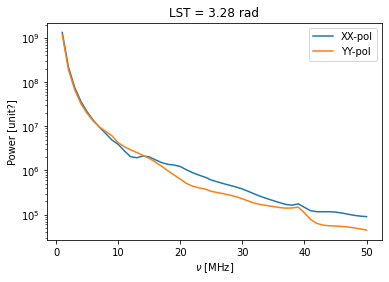

In [141]:
plt.figure()
plt.plot(freq/1e6, vis[0, :, 0], label="XX-pol")
plt.plot(freq/1e6, vis[0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Power [unit?]")
plt.title("LST = {:.2f} rad".format(lst_arr[0]))
plt.yscale("log")
plt.show()

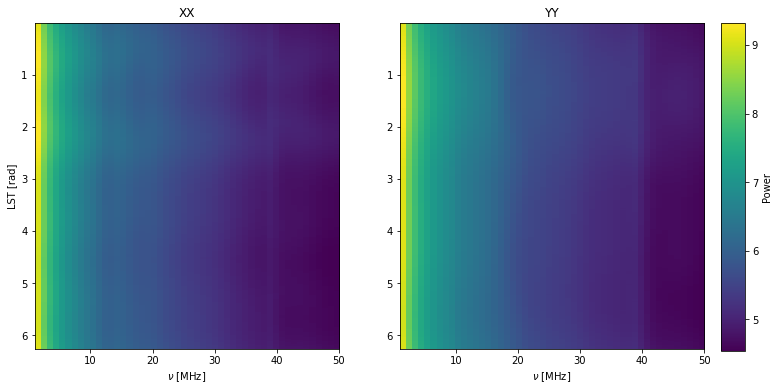

In [142]:
extent = [freq.min()/1e6, freq.max()/1e6, lst_arr.max(), lst_arr.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 0]), mode='real', extent=extent)
#im.set_clim(0, 0.45)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 1]), mode='real', extent=extent)
#im.set_clim(0, 0.45)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="Power")

## Compute eigenmodes

In [143]:
pols = ["XX", "YY"]

idata = vis[:, :, :2]  # uncalibrated, nspws=0, no crosspols
d = idata - np.mean(idata, axis=0)  # subtract mean in time

V_full = np.empty((freq.size, freq.size, 2)) # eigenvector change of basis
for i, _ in enumerate(pols):  # compute for both XX and YY
    C = np.dot(d[:, :, i].T, d[:, :, i])  # covariance matrix
    U, S, V = np.linalg.svd(C)
    V_full[:, :, i] = V 

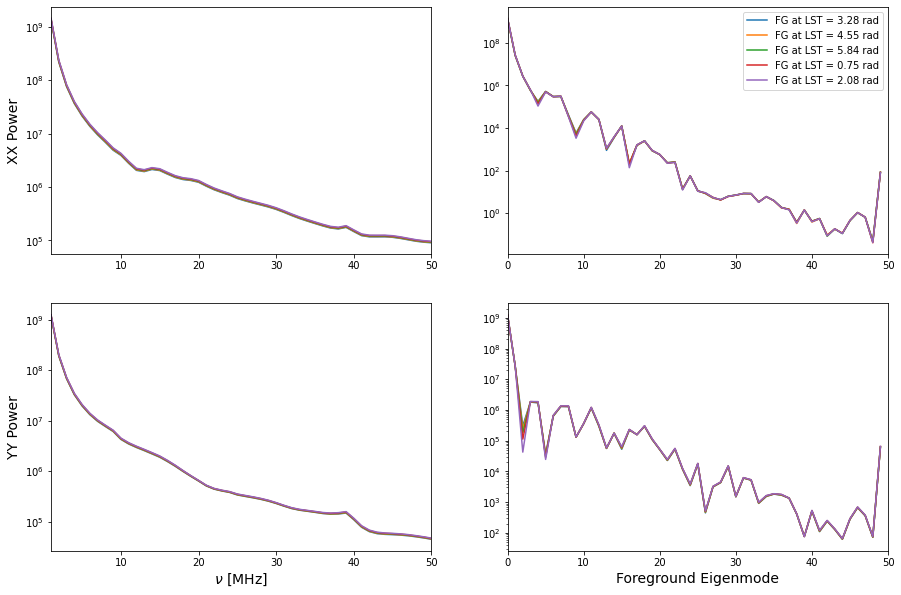

In [155]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

for i, lst in enumerate(lst_arr[::50]):
    axs[0, 0].plot(freq/1e6, np.abs(idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[0, 1].plot(np.abs(V_full[:, :, 0] @ idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 0].plot(freq/1e6, np.abs(idata[i, :, 1]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 1].plot(np.abs(V_full[:, :, 0] @ idata[i, :, 1]), label="FG at LST = {:.2f} rad".format(lst))

plt.setp(axs[:, 0], yscale="symlog", xlim=(freq.min()/1e6, freq.max()/1e6))
plt.setp(axs[:, 1], yscale="log", xlim=(0, len(V_full)))
axs[1, 0].set_xlabel("$\\nu$ [MHz]", fontsize=14)
axs[1, 1].set_xlabel("Foreground Eigenmode", fontsize=14)
for i, pol in enumerate(pols):
    axs[i, 0].set_ylabel(f"{pol} Power", fontsize=14)
axs[0, 1].legend()

plt.show()